In [36]:
import lightgbm as lgb
import hyperopt as hp
from numpy.random import RandomState
import sklearn as sk
import pandas as pd

In [2]:
train = pd.read_csv(filepath_or_buffer="../../Desktop/dataF.csv",encoding='gbk')
train = pd.DataFrame(train)

In [3]:
train.columns = ['Q4', 'Q5', 'Q6',
       '微信', '链接', '手机提交', '纸质问卷', '大连', '盘锦', '沈阳', '葫芦岛', '哈尔滨', '商丘', '未知',
       'second', 'minute', 'hour', '所用时间', 'Q1.您的年级', 'Q2.您的性别',
       'Q3.A.课堂学习.包括但不限于学校..', 'Q3.B.网络社交平台.', 'Q3.C.书籍杂志.', 'Q3.D.纪录片.',
       'Q3.E.娱乐节目.', 'Q3.F.旁人讲述.', 'Q3.G.有生活经历.', 'Q3.H.完全不了解.', 'Q3.I.其他..',
       'Q7.在以上三种文化中您认为最具研究价值的是.', 'Q8.您认为最能体现以上三种文化差异的地方在于.',
       'Q9..您对.不同地域文化之间存在区别又存在联系.的观点的认同程度..1.5打分.', 'Q10.您认为研究不同地域文化的价值在于.']
train[:]

Q4  Q5  Q6  微信  链接  手机提交  纸质问卷  大连  盘锦  沈阳  ...  Q3.D.纪录片.  Q3.E.娱乐节目.  \
0    4   3   3   0   0     0     0   0   0   1  ...          1           0   
1    3   3   4   1   0     0     0   1   0   0  ...          1           1   
2    3   3   4   1   0     0     0   1   0   0  ...          0           1   
3    2   2   3   1   0     0     0   1   0   0  ...          0           1   
4    2   3   2   1   0     0     0   0   0   0  ...          1           0   
..  ..  ..  ..  ..  ..   ...   ...  ..  ..  ..  ...        ...         ...   
91   2   3   3   0   0     0     0   1   0   0  ...          1           0   
92   2   1   1   0   0     0     0   1   0   0  ...          0           0   
93   3   2   2   0   0     0     0   1   0   0  ...          0           1   
94   3   2   3   0   0     0     0   1   0   0  ...          1           1   
95   2   3   3   0   0     0     0   1   0   0  ...          1           0   

    Q3.F.旁人讲述.  Q3.G.有生活经历.  Q3.H.完全不了解.  Q3.I.其他..  Q7.在以上三种文化中您认为最具研究价值的是.  \
0            0            1            0          0                        1   
1            0            0            0          0                        3   
2            0            0            0          0                        3   
3            1            0            0          0                        2   
4            0            0            0          0                        3   
..         ...          ...          ...        ...                      ...   
91           0            0            0          0                        2   
92           0            1            0          0                        1   
93           0            0            0          0                        1   
94           0            0            0          0                        3   
95           0            0            0          0                        1   

    Q8.您认为最能体现以上三种文化差异的地方在于.  Q9..您对.不同地域文化之间存在区别又存在联系.的观点的认同程度..1.5打分.  \
0                          1                                          5   
1                          1                                          3   
2                          2                                          4   
3                          3                                          3   
4                          1                                          5   
..                       ...                                        ...   
91                         2                                          5   
92                         2                                          3   
93                         1                                          5   
94                         1                                          4   
95                         1                                          4   

    Q10.您认为研究不同地域文化的价值在于.  
0                       1  
1                       2  
2                       2  
3                       1  
4                       2  
..                    ...  
91                      2  
92                      1  
93                      3  
94                      3  
95                      1  

[96 rows x 33 columns]

In [5]:
def  params_append(params):
    params['objective'] = 'regression'
    params['metric'] = 'mae'
    params['bagging_seed'] = 2020
    params['feature_pre_filter']=False
    return params

In [14]:
def param_hyperopt(train):
    label = [f for f in train.columns if f in ['Q4']]
    features = [f for f in train.columns if f not in ['Q4']]
    train_data = lgb.Dataset(train[features],train[label],silent=True)
    def hyperopt_objective(params):
        params = params_append(params)
        print(params)
        res = lgb.cv(params,train_data,1000,nfold=2,stratified=False,shuffle=True,metrics='rmse',
                     early_stopping_rounds=20,verbose_eval=False,show_stdv=False)
        return min(res['rmse-mean'])
    #参数空间
    params_space = {
        'learning_rate': hp.hp.uniform('learning_rate',1e-2,5e-1),
        'bagging_fraction': hp.hp.uniform('bagging_fraction',0.5,1),
        'feature_fraction': hp.hp.uniform('feature_fraction',0.5,1),
        'num_leaves': hp.hp.choice('num_leaves',list(range(10,300,10))),
        'reg_alpha': hp.hp.randint('reg_alpha',0,10),
        'reg_lambda': hp.hp.uniform('reg_lambda',0,10),
        'bagging_freq': hp.hp.randint('bagging_freq',1,10),
        'min_child_samples': hp.hp.choice('min_child_samples',list(range(1,30,5)))
    }
    params_best = hp.fmin(
        hyperopt_objective,
        space=params_space,
        algo=hp.tpe.suggest,
        max_evals=3000,
#         rstate=RandomState(2020)
    )
    return params_best

In [15]:
params = param_hyperopt(train)

{'bagging_fraction': 0.7721141606229321, 'bagging_freq': 3, 'feature_fraction': 0.7527993301589113, 'learning_rate': 0.3868949884020992, 'min_child_samples': 11, 'num_leaves': 170, 'reg_alpha': 9, 'reg_lambda': 1.4980330574627243, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000483 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

d:\python\lib\site-packages\lightgbm\engine.py:577: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "

d:\python\lib\site-packages\lightgbm\basic.py:1491: UserWarning: 'silent' argument is deprecated and will be removed in a future release of LightGBM. Pass 'verbose' parameter via 'params' instead.
  _log_warning("'silent' argument is deprecated and will be removed in a future release of LightGBM. "

d:\python\lib\site-packages\lightgbm\engine.py:620: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "



{'bagging_fraction': 0.9188334812634165, 'bagging_freq': 4, 'feature_fraction': 0.8269438227040072, 'learning_rate': 0.4277023518021894, 'min_child_samples': 16, 'num_leaves': 230, 'reg_alpha': 5, 'reg_lambda': 4.887540270200058, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.552481380134812, 'bagging_freq': 2, 'feature_fraction': 0.8213640539120936, 'learning_rate': 0.38386895727058395, 'min_child_samples': 21, 'num_leaves': 150, 'reg_alpha': 9, 'reg_lambda': 0.9612075183950475, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5652315664756042, 'bagging_freq': 4, 'feature_fraction': 0.8831421689332879, 'learning_rate': 0.07800804125626812, 'min_child_samples': 6, 'num_leaves': 250, 'reg_alpha': 0, 'reg_lambda': 2.967390719853371, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5061657884041132, 'bagging_freq': 9, 'feature_fraction': 0.6492163001359128, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6129196624364154, 'bagging_freq': 7, 'feature_fraction': 0.8894637220049946, 'learning_rate': 0.24242289590062965, 'min_child_samples': 6, 'num_leaves': 110, 'reg_alpha': 1, 'reg_lambda': 4.727445937784202, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7695085116563694, 'bagging_freq': 3, 'feature_fraction': 0.569092946349831, 'learning_rate': 0.2288633341627688, 'min_child_samples': 21, 'num_leaves': 260, 'reg_alpha': 2, 'reg_lambda': 4.059274548065312, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5295449496239

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7254342378791068, 'bagging_freq': 2, 'feature_fraction': 0.8729794075614675, 'learning_rate': 0.13323535152656205, 'min_child_samples': 16, 'num_leaves': 160, 'reg_alpha': 3, 'reg_lambda': 3.372214569544637, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.9198133336318083, 'bagging_freq': 8, 'feature_fraction': 0.9004277508792091, 'learning_rate': 0.20500977597659284, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 2, 'reg_lambda': 0.466874912850336, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000135 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6281464889579

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.9976460909067876, 'bagging_freq': 8, 'feature_fraction': 0.9018764116366221, 'learning_rate': 0.257348476091733, 'min_child_samples': 6, 'num_leaves': 180, 'reg_alpha': 6, 'reg_lambda': 2.5956679491485377, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7752216748022539, 'bagging_freq': 8, 'feature_fraction': 0.9605121691882419, 'learning_rate': 0.04524282357776538, 'min_child_samples': 16, 'num_leaves': 70, 'reg_alpha': 4, 'reg_lambda': 2.2734836664930884, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.9249089345807867, 'bagging_freq': 6, 'feature_fraction': 0.811779171709308, 'learning_rate': 0.3151414583683704, 'min_child_samples': 6, 'num_leaves': 100, 'reg_alpha': 2, 'reg_lambda': 1.9939703383237433, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.8607369052848937, 'bagging_freq': 9, 'feature_fraction': 0.8350716347643242, 'learning_rate': 0.24471571196596387, 'min_child_samples': 26, 'num_leaves': 160, 'reg_alpha': 3, 'reg_lambda': 0.5930873315527818, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7997557358737

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7665108047613288, 'bagging_freq': 3, 'feature_fraction': 0.5754401912992169, 'learning_rate': 0.4080259918650415, 'min_child_samples': 16, 'num_leaves': 110, 'reg_alpha': 1, 'reg_lambda': 0.09166319808069523, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhe

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7381828436716983, 'bagging_freq': 2, 'feature_fraction': 0.5727355685507513, 'learning_rate': 0.35353804432502023, 'min_child_samples': 16, 'num_leaves': 60, 'reg_alpha': 9, 'reg_lambda': 0.4378777125922968, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000433 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6036913289301

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5749790976703782, 'bagging_freq': 5, 'feature_fraction': 0.6248858512882938, 'learning_rate': 0.47624988020318754, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 3.1837710659294327, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

{'bagging_fraction': 0.5941409965399608, 'bagging_freq': 5, 'feature_fraction': 0.5850193532102305, 'learning_rate': 0.43100728627361873, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 5.27233861568277, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5626660322659515, 'bagging_freq': 5, 'feature_fraction': 0.5507310965776228, 'learning_rate': 0.4010195909438268, 'min_child_samples': 1, 'num_leaves': 240, 'reg_alpha': 3, 'reg_lambda': 4.606617224415179, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6258732726351861, 'bagging_freq': 4, 'feature_fraction': 0.6207843101496833, 'learning_rate': 0.49983268447475226, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 8, 'reg_lambda': 4.7913938854733775, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000131 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5508733416911

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000142 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5163378742786273, 'bagging_freq': 5, 'feature_fraction': 0.5023319732774769, 'learning_rate': 0.3695916684185799, 'min_child_samples': 1, 'num_leaves': 250, 'reg_alpha': 3, 'reg_lambda': 5.815047743096864, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000171 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info

{'bagging_fraction': 0.5072813950890028, 'bagging_freq': 5, 'feature_fraction': 0.5547288441027188, 'learning_rate': 0.4989590218116776, 'min_child_samples': 26, 'num_leaves': 120, 'reg_alpha': 8, 'reg_lambda': 4.133693659070453, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000263 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6903535501274305, 'bagging_freq': 9, 'feature_fraction': 0.6385368152803519, 'learning_rate': 0.40733144286738243, 'min_child_samples': 1, 'num_leaves': 290, 'reg_alpha': 9, 'reg_lambda': 4.758055184801752, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warni

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5225918198832892, 'bagging_freq': 5, 'feature_fraction': 0.5022738682014676, 'learning_rate': 0.44099758208372086, 'min_child_samples': 1, 'num_leaves': 250, 'reg_alpha': 8, 'reg_lambda': 3.7350508132705214, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5622558640837

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5247189634115766, 'bagging_freq': 4, 'feature_fraction': 0.6878411406173727, 'learning_rate': 0.35401958607367545, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 8, 'reg_lambda': 6.194483750501628, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6112629860371159, 'bagging_freq': 7, 'feature_fraction': 0.5904122198578933, 'learning_rate': 0.36557278328576287, 'min_child_samples': 26, 'num_leaves': 120, 'reg_alpha': 1, 'reg_lambda': 6.404919503262777, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5667423333899

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000307 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5739789135430485, 'bagging_freq': 6, 'feature_fraction': 0.6272737437881738, 'learning_rate': 0.3101201740976701, 'min_child_samples': 1, 'num_leaves': 80, 'reg_alpha': 9, 'reg_lambda': 3.0011308119161777, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5594885844126143, 'bagging_freq': 1, 'feature_fraction': 0.5842941999192316, 'learning_rate': 0.4241389359835493, 'min_child_samples': 11, 'num_leaves': 180, 'reg_alpha': 5, 'reg_lambda': 3.3519772636128495, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `for

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6189534605338

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7044008499671264, 'bagging_freq': 9, 'feature_fraction': 0.5928780569523416, 'learning_rate': 0.28544260673387395, 'min_child_samples': 21, 'num_leaves': 170, 'reg_alpha': 0, 'reg_lambda': 3.5577636650705684, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [I

{'bagging_fraction': 0.5521713506394739, 'bagging_freq': 9, 'feature_fraction': 0.554755888266867, 'learning_rate': 0.3209768370904651, 'min_child_samples': 1, 'num_leaves': 110, 'reg_alpha': 6, 'reg_lambda': 3.3061485459617117, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7157137909014926, 'bagging_freq': 7, 'feature_fraction': 0.6066115801021419, 'learning_rate': 0.37252068493446544, 'min_child_samples': 1, 'num_leaves': 290, 'reg_alpha': 3, 'reg_lambda': 1.5237370860186688, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6011353336111682, 'bagging_freq': 8, 'feature_fraction': 0.5182785588784447, 'learning_rate': 0.2725015310018607, 'min_child_samples': 1, 'num_leaves': 50, 'reg_alpha': 8, 'reg_lambda': 4.755852994960369, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5679590205123

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7067062390179492, 'bagging_freq': 6, 'feature_fraction': 0.6320987116836636, 'learning_rate': 0.3399137031862793, 'min_child_samples': 21, 'num_leaves': 290, 'reg_alpha': 8, 'reg_lambda': 5.472141039842111, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5868842069344018, 'bagging_freq': 5, 'feature_fraction': 0.5100170664284033, 'learning_rate': 0.3989260825892892, 'min_child_samples': 1, 'num_leaves': 260, 'reg_alpha': 1, 'reg_lambda': 5.767307133154943, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6416300966947

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000205 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5398619856770898, 'bagging_freq': 5, 'feature_fraction': 0.5440215122683404, 'learning_rate': 0.41934773811975246, 'min_child_samples': 11, 'num_leaves': 260, 'reg_alpha': 1, 'reg_lambda': 5.182644737659168, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `for

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.620571614875351, 'bagging_freq': 5, 'feature_fraction': 0.5553829441069487, 'learning_rate': 0.3473749977503731, 'min_child_samples': 1, 'num_leaves': 240, 'reg_alpha': 7, 'reg_lambda': 6.853441760382158, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6124351622334

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.67505242885319, 'bagging_freq': 1, 'feature_fraction': 0.6235112449577549, 'learning_rate': 0.4450449772156542, 'min_child_samples': 6, 'num_leaves': 290, 'reg_alpha': 7, 'reg_lambda': 6.057525033014286, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5560515764355761, 'bagging_freq': 5, 'feature_fraction': 0.5084911101405702, 'learning_rate': 0.3234014485413676, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 3, 'reg_lambda': 6.361570685935114, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000147 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5479180066018

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6808054282105234, 'bagging_freq': 8, 'feature_fraction': 0.6017075739997274, 'learning_rate': 0.05736459036724148, 'min_child_samples': 1, 'num_leaves': 240, 'reg_alpha': 3, 'reg_lambda': 6.139978423247845, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7130998016889607, 'bagging_freq': 5, 'feature_fraction': 0.5324113235712766, 'learning_rate': 0.3572585868323009, 'min_child_samples': 11, 'num_leaves': 200, 'reg_alpha': 1, 'reg_lambda': 5.710280825930944, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5002350287956336, 'bagging_freq': 8, 'feature_fraction': 0.6289759735056689, 'learning_rate': 0.2503523656247537, 'min_child_samples': 1, 'num_leaves': 180, 'reg_alpha': 3, 'reg_lambda': 7.038309629953281, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7033771230701821, 'bagging_freq': 1, 'feature_fraction': 0.9532274498200426, 'learning_rate': 0.47382228552366346, 'min_child_samples': 1, 'num_leaves': 30, 'reg_alpha': 5, 'reg_lambda': 8.563662751931288, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000158 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5431975111307

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000244 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.593508462107754, 'bagging_freq': 7, 'feature_fraction': 0.5004428447454773, 'learning_rate': 0.4200700969834121, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 5, 'reg_lambda': 5.3719051083284395, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7446096985973089, 'bagging_freq': 5, 'feature_fraction': 0.5416948158590653, 'learning_rate': 0.48429075696605567, 'min_child_samples': 11, 'num_leaves': 40, 'reg_alpha': 7, 'reg_lambda': 7.201001228362874, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5479003605859

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.8274720325525279, 'bagging_freq': 4, 'feature_fraction': 0.6072245439744927, 'learning_rate': 0.45324070928558413, 'min_child_samples': 16, 'num_leaves': 20, 'reg_alpha': 1, 'reg_lambda': 4.1488025919645395, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5836341107608881, 'bagging_freq': 7, 'feature_fraction': 0.6748682247539466, 'learning_rate': 0.3337097364015024, 'min_child_samples': 6, 'num_leaves': 250, 'reg_alpha': 1, 'reg_lambda': 4.782445920948181, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000241 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6398824479891094, 'bagging_freq': 4, 'feature_fraction': 0.5356173092102476, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5075287813237003, 'bagging_freq': 7, 'feature_fraction': 0.7063260766233742, 'learning_rate': 0.306036837181808, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 3, 'reg_lambda': 2.8964050586853434, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.9849228145996947, 'bagging_freq': 5, 'feature_fraction': 0.5239556878509227, 'learning_rate': 0.3869279372000882, 'min_child_samples': 1, 'num_leaves': 190, 'reg_alpha': 5, 'reg_lambda': 0.5697316095951339, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7257598993980

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6417211376808111, 'bagging_freq': 3, 'feature_fraction': 0.560816503365658, 'learning_rate': 0.37169175657404596, 'min_child_samples': 1, 'num_leaves': 220, 'reg_alpha': 1, 'reg_lambda': 4.401211283432184, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

{'bagging_fraction': 0.5720035493562279, 'bagging_freq': 9, 'feature_fraction': 0.5335230741366244, 'learning_rate': 0.31804738919885395, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 4.352186884289939, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6053734517515372, 'bagging_freq': 9, 'feature_fraction': 0.568957216013072, 'learning_rate': 0.23581707810425073, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 3.061182354645755, 'objective': 'regression', 'metric': 'mae', 'baggi

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6186330756934082, 'bagging_freq': 9, 'feature_fraction': 0.611236723415142, 'learning_rate': 0.1758847458841932, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 2.5403450185800995, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000212 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.9346012428205072, 'bagging_freq': 9, 'feature_fraction': 0.653785373949319, '

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6516416084451108, 'bagging_freq': 9, 'feature_fraction': 0.5569307118921206, 'learning_rate': 0.2236502429176112, 'min_child_samples': 21, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 3.464787302205644, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6699509952402407, 'bagging_freq': 9, 'feature_fraction': 0.5654438496400324, 'learning_rate': 0.15091698469613402, 'min_child_samples': 11, 'num_leaves': 110, 'reg_alpha': 0, 'reg_lambda': 3.6911879622343546, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhe

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6069896504057

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000233 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.600396382429749, 'bagging_freq': 9, 'feature_fraction': 0.5781890151663014, 'learning_rate': 0.15800592584292503, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 3.047199808152534, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000081 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000083 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6037540555897

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5798298884500412, 'bagging_freq': 9, 'feature_fraction': 0.6416578067228523, 'learning_rate': 0.2748416865297445, 'min_child_samples': 16, 'num_leaves': 190, 'reg_alpha': 0, 'reg_lambda': 4.542952672437299, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.             
You can set `forc

{'bagging_fraction': 0.5593425952832219, 'bagging_freq': 9, 'feature_fraction': 0.5366776157663788, 'learning_rate': 0.29591344675425946, 'min_child_samples': 26, 'num_leaves': 280, 'reg_alpha': 5, 'reg_lambda': 3.0190435560704296, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000363 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5839811069857841, 'bagging_freq': 9, 'feature_fraction': 0.5691651016317834, 'learning_rate': 0.13026848224399581, 'min_child_samples': 1, 'num_leaves': 110, 'reg_alpha': 0, 'reg_lambda': 4.073795208616919, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6206132351288036, 'bagging_freq': 9, 'feature_fraction': 0.5446955043732112, 'learning_rate': 0.22813176962397014, 'min_child_samples': 26, 'num_leaves': 50, 'reg_alpha': 0, 'reg_lambda': 3.9432333722823456, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000175 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000216 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5590287594042775, 'bagging_freq': 2, 'feature_fraction': 0.5308031465617503, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5144906235617033, 'bagging_freq': 3, 'feature_fraction': 0.5661111012493042, 'learning_rate': 0.047252312307701216, 'min_child_samples': 6, 'num_leaves': 60, 'reg_alpha': 0, 'reg_lambda': 2.9814604389126025, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

{'bagging_fraction': 0.7557657666196476, 'bagging_freq': 2, 'feature_fraction': 0.5717151377258547, 'learning_rate': 0.34552528952499056, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 7, 'reg_lambda': 3.6927604126896796, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.540049676436694, 'bagging_freq': 9, 'feature_fraction': 0.9643752993063825, 'learning_rate': 0.2677664272054733, 'min_child_samples': 6, 'num_leaves': 160, 'reg_alpha': 4, 'reg_lambda': 2.2302860135322895, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5494413459596649, 'bagging_freq': 1, 'feature_fraction': 0.763146188965867, 'learning_rate': 0.33962525869887056, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 1.9241515626704961, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5076241853567

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5664359333259973, 'bagging_freq': 7, 'feature_fraction': 0.5592503917855685, 'learning_rate': 0.07847045610801567, 'min_child_samples': 21, 'num_leaves': 130, 'reg_alpha': 8, 'reg_lambda': 3.988882768382006, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6529762440086739, 'bagging_freq': 9, 'feature_fraction': 0.5520892852991782, 'learning_rate': 0.13986372986490345, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 3, 'reg_lambda': 5.240891263353859, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6217388556517

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000222 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6291711963812211, 'bagging_freq': 4, 'feature_fraction': 0.5780921451543267, 'learning_rate': 0.2924161851979932, 'min_child_samples': 11, 'num_leaves': 100, 'reg_alpha': 9, 'reg_lambda': 2.0290805218648345, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `for

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5126390482571862, 'bagging_freq': 9, 'feature_fraction': 0.5434241469026755, 'learning_rate': 0.3587750018914796, 'min_child_samples': 21, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 4.410330424296438, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6330414331399

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000200 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.554355325208464, 'bagging_freq': 9, 'feature_fraction': 0.5504851326308131, 'learning_rate': 0.23348506941577118, 'min_child_samples': 1, 'num_leaves': 30, 'reg_alpha': 4, 'reg_lambda': 3.9466844712675684, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

{'bagging_fraction': 0.5364950144830151, 'bagging_freq': 8, 'feature_fraction': 0.5267052169807862, 'learning_rate': 0.19608603373608996, 'min_child_samples': 1, 'num_leaves': 250, 'reg_alpha': 8, 'reg_lambda': 5.270957933687176, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5576330677345294, 'bagging_freq': 9, 'feature_fraction': 0.5861095897277058, 'learning_rate': 0.21936896041984688, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 2.358940518531528, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5729165989754288, 'bagging_freq': 9, 'feature_fraction': 0.547912721204636, 'learning_rate': 0.1695596281402904, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 2.263854827575501, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5443633231216

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000192 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5587959415970208, 'bagging_freq': 1, 'feature_fraction': 0.5435921743748852, 'learning_rate': 0.23267184500701255, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 4, 'reg_lambda': 1.9809273608104072, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5648929952241463, 'bagging_freq': 8, 'feature_fraction': 0.5830678142361821, 'learning_rate': 0.19589828899337236, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 1.2915343738733758, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5647741217277

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6291034549333631, 'bagging_freq': 8, 'feature_fraction': 0.5709700835729047, 'learning_rate': 0.1631861526339231, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 5, 'reg_lambda': 3.5055557095519094, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.650753186206247, 'bagging_freq': 7, 'feature_fraction': 0.9884828135342383, 'learning_rate': 0.12869505516495464, 'min_child_samples': 1, 'num_leaves': 30, 'reg_alpha': 2, 'reg_lambda': 0.1035832724597876, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6372046326992389, 'bagging_freq': 8, 'feature_fraction': 0.525775277373683, 'learning_rate': 0.21089234894828177, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 2.278325918308083, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6284471651635671, 'bagging_freq': 1, 'feature_fraction': 0.5178263943567386, 'learning_rate': 0.2160683353076111, 'min_child_samples': 1, 'num_leaves': 290, 'reg_alpha': 8, 'reg_lambda': 1.9146917442409472, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6002447928836

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6739229288667397, 'bagging_freq': 9, 'feature_fraction': 0.6062768380030529, 'learning_rate': 0.12514676904875205, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 2.8320118951357833, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5815954641903318, 'bagging_freq': 9, 'feature_fraction': 0.6381702701926523, 'learning_rate': 0.1805558322352735, 'min_child_samples': 1, 'num_leaves': 220, 'reg_alpha': 3, 'reg_lambda': 2.8438365702726, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000546 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5759793139831

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000129 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6403787044364433, 'bagging_freq': 3, 'feature_fraction': 0.6317576302391383, 'learning_rate': 0.22602679069207468, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 1.8493725929665406, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.607605165643034, 'bagging_freq': 9, 'feature_fraction': 0.5478708043129383, 'learning_rate': 0.2945034033454599, 'min_child_samples': 11, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 0.5977158961644573, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000218 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5584042969687844, 'bagging_freq': 9, 'feature_fraction': 0.5541864205855628, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000307 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6862475860808903, 'bagging_freq': 8, 'feature_fraction': 0.6637751500126648, 'learning_rate': 0.09601526025812038, 'min_child_samples': 11, 'num_leaves': 110, 'reg_alpha': 6, 'reg_lambda': 2.3742669352549566, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.542649237253276, 'bagging_freq': 1, 'feature_fraction': 0.6257766321647779, 'learning_rate': 0.335220591745352, 'min_child_samples': 1, 'num_leaves': 140, 'reg_alpha': 0, 'reg_lambda': 3.0899309329939237, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5776101444489

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5374859984229512, 'bagging_freq': 9, 'feature_fraction': 0.6528251906059139, 'learning_rate': 0.1609556263394318, 'min_child_samples': 1, 'num_leaves': 290, 'reg_alpha': 0, 'reg_lambda': 3.0153332322274524, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6094598635792376, 'bagging_freq': 6, 'feature_fraction': 0.5609958295931049, 'learning_rate': 0.18550132979480485, 'min_child_samples': 1, 'num_leaves': 170, 'reg_alpha': 2, 'reg_lambda': 3.767803793075181, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5823911095558

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000211 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5517144284171106, 'bagging_freq': 7, 'feature_fraction': 0.6244920075176775, 'learning_rate': 0.2179266821747774, 'min_child_samples': 1, 'num_leaves': 160, 'reg_alpha': 7, 'reg_lambda': 4.591654244176437, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5208604724476473, 'bagging_freq': 9, 'feature_fraction': 0.5135399051314629, 'learning_rate': 0.12636658450555965, 'min_child_samples': 1, 'num_leaves': 80, 'reg_alpha': 0, 'reg_lambda': 1.2419619042145928, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7371493993552832, 'bagging_freq': 9, 'feature_fraction': 0.8180121968456049, 'learning_rate': 0.2352613352266706, 'min_child_samples': 1, 'num_leaves': 150, 'reg_alpha': 8, 'reg_lambda': 5.275076629548737, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5009811612122844, 'bagging_freq': 5, 'feature_fraction': 0.6808588510403825, 'learning_rate': 0.3004606168467462, 'min_child_samples': 1, 'num_leaves': 170, 'reg_alpha': 9, 'reg_lambda': 3.609162441603039, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000383 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6397081582777

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000216 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.552116276424486, 'bagging_freq': 1, 'feature_fraction': 0.5695826767250644, 'learning_rate': 0.3315391399282329, 'min_child_samples': 1, 'num_leaves': 250, 'reg_alpha': 2, 'reg_lambda': 0.7885673219858527, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5260926379592309, 'bagging_freq': 9, 'feature_fraction': 0.5984608845262842, 'learning_rate': 0.1774202607911938, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 4.411991800384464, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.8052040615642

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.576657394329174, 'bagging_freq': 6, 'feature_fraction': 0.5486983483646256, 'learning_rate': 0.2216027786582926, 'min_child_samples': 6, 'num_leaves': 20, 'reg_alpha': 9, 'reg_lambda': 5.134864322815208, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5237940037743496, 'bagging_freq': 8, 'feature_fraction': 0.5538818817785035, 'learning_rate': 0.2562409581164767, 'min_child_samples': 1, 'num_leaves': 130, 'reg_alpha': 4, 'reg_lambda': 2.3143847332238017, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `forc

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5750114312649599, 'bagging_freq': 9, 'feature_fraction': 0.5727731911760219, 'learning_rate': 0.13726118312041793, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 3.282686214462099, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6042403335779297, 'bagging_freq': 9, 'feature_fraction': 0.6135440255484761, 'learning_rate': 0.1742748223130927, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 3.4840037056629396, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6201526592046057, 'bagging_freq': 9, 'feature_fraction': 0.5581558450951833, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000155 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.605866608866514, 'bagging_freq': 9, 'feature_fraction': 0.5434307055374477, 'learning_rate': 0.2420299325038604, 'min_child_samples': 1, 'num_leaves': 40, 'reg_alpha': 0, 'reg_lambda': 2.122395611586401, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

{'bagging_fraction': 0.5355901946804366, 'bagging_freq': 9, 'feature_fraction': 0.6019809508337437, 'learning_rate': 0.23175413072436576, 'min_child_samples': 1, 'num_leaves': 50, 'reg_alpha': 7, 'reg_lambda': 3.0308443181888567, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5835420567493084, 'bagging_freq': 9, 'feature_fraction': 0.609160402055373, 'learning_rate': 0.24577114038388204, 'min_child_samples': 6, 'num_leaves': 60, 'reg_alpha': 6, 'reg_lambda': 2.3549833932696247, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5607490830276121, 'bagging_freq': 9, 'feature_fraction': 0.5321868673640126, 'learning_rate': 0.1421210527299769, 'min_child_samples': 1, 'num_leaves': 130, 'reg_alpha': 0, 'reg_lambda': 3.715568432726053, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5540682901816

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6435186593535756, 'bagging_freq': 4, 'feature_fraction': 0.6008787575478323, 'learning_rate': 0.271834087154995, 'min_child_samples': 1, 'num_leaves': 220, 'reg_alpha': 0, 'reg_lambda': 2.034486722537882, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

{'bagging_fraction': 0.5757399640312652, 'bagging_freq': 9, 'feature_fraction': 0.5754578830290245, 'learning_rate': 0.2279964227053345, 'min_child_samples': 1, 'num_leaves': 50, 'reg_alpha': 0, 'reg_lambda': 2.2941070450254113, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6502906056913972, 'bagging_freq': 9, 'feature_fraction': 0.6031080007382099, 'learning_rate': 0.13672362874927302, 'min_child_samples': 16, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 2.899949023895176, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6868345025825059, 'bagging_freq': 9, 'feature_fraction': 0.6126525562872865, 'learning_rate': 0.20954223478621878, 'min_child_samples': 1, 'num_leaves': 260, 'reg_alpha': 0, 'reg_lambda': 2.1897155974505966, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5898065628881

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000188 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5688773369874, 'bagging_freq': 3, 'feature_fraction': 0.6036023439929658, 'learning_rate': 0.2281532256916881, 'min_child_samples': 21, 'num_leaves': 30, 'reg_alpha': 9, 'reg_lambda': 2.2987406847664, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5858470367562776, 'bagging_freq': 9, 'feature_fraction': 0.5967136853614554, 'learning_rate': 0.12169095167226224, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 4, 'reg_lambda': 3.0531901887898325, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6592943489595

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5918851438124643, 'bagging_freq': 4, 'feature_fraction': 0.6446114890828691, 'learning_rate': 0.17538868150766299, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 9, 'reg_lambda': 1.7817233735404927, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5838856958786901, 'bagging_freq': 9, 'feature_fraction': 0.534858315565297, 'learning_rate': 0.3221346872965376, 'min_child_samples': 1, 'num_leaves': 150, 'reg_alpha': 0, 'reg_lambda': 3.8087872880376006, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5528779763639283, 'bagging_freq': 9, 'feature_fraction': 0.5283113921744736, 'learning_rate': 0.37258952480769914, 'min_child_samples': 26, 'num_leaves': 150, 'reg_alpha': 0, 'reg_lambda': 3.076493239928938, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5421872690652216, 'bagging_freq': 5, 'feature_fraction': 0.6220176511814156, 'learning_rate': 0.09123413403008535, 'min_child_samples': 16, 'num_leaves': 20, 'reg_alpha': 1, 'reg_lambda': 3.9070164946280754, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6014238906155

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.8754478629199602, 'bagging_freq': 9, 'feature_fraction': 0.5023186756891028, 'learning_rate': 0.2043944967701393, 'min_child_samples': 1, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 2.7384131959725915, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.618964506842786, 'bagging_freq': 9, 'feature_fraction': 0.6072339576596054, 'learning_rate': 0.27296024231899785, 'min_child_samples': 21, 'num_leaves': 10, 'reg_alpha': 1, 'reg_lambda': 3.352279271413693, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5869022711640031, 'bagging_freq': 5, 'feature_fraction': 0.5155669925071624, 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000176 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6689338152015446, 'bagging_freq': 9, 'feature_fraction': 0.5788017251311317, 'learning_rate': 0.2086395073731165, 'min_child_samples': 1, 'num_leaves': 250, 'reg_alpha': 0, 'reg_lambda': 4.175033010795439, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

{'bagging_fraction': 0.5970250067105393, 'bagging_freq': 2, 'feature_fraction': 0.510556764719161, 'learning_rate': 0.3200531423248594, 'min_child_samples': 6, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 4.955923597654738, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5009746569441711, 'bagging_freq': 6, 'feature_fraction': 0.5269873223588434, 'learning_rate': 0.4068634904036623, 'min_child_samples': 1, 'num_leaves': 130, 'reg_alpha': 1, 'reg_lambda': 3.9937491951524193, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6219780422045046, 'bagging_freq': 4, 'feature_fraction': 0.5877533949153095, 'learning_rate': 0.08213070256831277, 'min_child_samples': 26, 'num_leaves': 250, 'reg_alpha': 2, 'reg_lambda': 1.7142335212249575, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6780856779335

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000156 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.57484461484872, 'bagging_freq': 3, 'feature_fraction': 0.6359770190726424, 'learning_rate': 0.16304423383074967, 'min_child_samples': 26, 'num_leaves': 10, 'reg_alpha': 0, 'reg_lambda': 2.9022826271565205, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7092111747324585, 'bagging_freq': 8, 'feature_fraction': 0.5629852928803781, 'learning_rate': 0.39648081395251167, 'min_child_samples': 1, 'num_leaves': 250, 'reg_alpha': 0, 'reg_lambda': 1.554509148244174, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5191173141238

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6534808219879379, 'bagging_freq': 9, 'feature_fraction': 0.5089955302270746, 'learning_rate': 0.1829546932769996, 'min_child_samples': 11, 'num_leaves': 250, 'reg_alpha': 0, 'reg_lambda': 1.7946617219134329, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

{'bagging_fraction': 0.5276820341689075, 'bagging_freq': 2, 'feature_fraction': 0.5732837684442733, 'learning_rate': 0.31185508958848024, 'min_child_samples': 1, 'num_leaves': 160, 'reg_alpha': 9, 'reg_lambda': 3.1525327152938036, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6095794510349867, 'bagging_freq': 6, 'feature_fraction': 0.6239345139653032, 'learning_rate': 0.14858600802231964, 'min_child_samples': 1, 'num_leaves': 80, 'reg_alpha': 0, 'reg_lambda': 2.089380356868293, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5835781671953666, 'bagging_freq': 5, 'feature_fraction': 0.8532105581840047, 'learning_rate': 0.4215070762336271, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 0.9360931837444102, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5899711984702

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5966532051140724, 'bagging_freq': 9, 'feature_fraction': 0.552379397611468, 'learning_rate': 0.3248758496660275, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 3.9176842215048655, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

{'bagging_fraction': 0.5831100782059999, 'bagging_freq': 9, 'feature_fraction': 0.5694456728781616, 'learning_rate': 0.3515334781079054, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 4.545316533385026, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5614913842304972, 'bagging_freq': 9, 'feature_fraction': 0.5285514942403523, 'learning_rate': 0.3443101621233051, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 5.584299212397244, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5355034908965115, 'bagging_freq': 9, 'feature_fraction': 0.5524516484569035, 'learning_rate': 0.33531271373257565, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 6.036878089650548, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5803333963946

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5552335656792684, 'bagging_freq': 3, 'feature_fraction': 0.5604739639051903, 'learning_rate': 0.36846861360596, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 5.907978811327916, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6301632009665

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6070229039576063, 'bagging_freq': 9, 'feature_fraction': 0.523981345113658, 'learning_rate': 0.43344520838408207, 'min_child_samples': 26, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 6.909700159723379, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5994720749815265, 'bagging_freq': 9, 'feature_fraction': 0.5378384358950703, 'learning_rate': 0.40418129810278197, 'min_child_samples': 16, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 7.090809229464751, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5487496640942

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.607310607414844, 'bagging_freq': 9, 'feature_fraction': 0.5738867205000763, 'learning_rate': 0.45118076363084264, 'min_child_samples': 11, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 5.715302689892168, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

{'bagging_fraction': 0.5284402827226865, 'bagging_freq': 9, 'feature_fraction': 0.5459056661800201, 'learning_rate': 0.47557891410472186, 'min_child_samples': 1, 'num_leaves': 30, 'reg_alpha': 9, 'reg_lambda': 5.890000929559443, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7581696577164415, 'bagging_freq': 1, 'feature_fraction': 0.5840654589979102, 'learning_rate': 0.3777907939646983, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 6.952736466587324, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6209555860398567, 'bagging_freq': 4, 'feature_fraction': 0.5374900775866919, 'learning_rate': 0.44653904933409044, 'min_child_samples': 11, 'num_leaves': 40, 'reg_alpha': 0, 'reg_lambda': 5.62753412037369, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6622596450314

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5898527982754267, 'bagging_freq': 3, 'feature_fraction': 0.8701571679349533, 'learning_rate': 0.40425509816699406, 'min_child_samples': 1, 'num_leaves': 130, 'reg_alpha': 5, 'reg_lambda': 6.707210504643756, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5760746623583805, 'bagging_freq': 8, 'feature_fraction': 0.5009969226305382, 'learning_rate': 0.4570445387393135, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 7, 'reg_lambda': 7.397524977067922, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000128 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6419511272023

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6153103229660093, 'bagging_freq': 9, 'feature_fraction': 0.5009518504411645, 'learning_rate': 0.3583208094227678, 'min_child_samples': 1, 'num_leaves': 290, 'reg_alpha': 0, 'reg_lambda': 5.575042710637874, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5860678052864738, 'bagging_freq': 9, 'feature_fraction': 0.560364634626163, 'learning_rate': 0.3947128481223549, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 5.441140994421715, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000198 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6377060949732043, 'bagging_freq': 6, 'feature_fraction': 0.5290930777830262, 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6315721619773143, 'bagging_freq': 9, 'feature_fraction': 0.5799733482393121, 'learning_rate': 0.3733848795550752, 'min_child_samples': 1, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 5.03146752468661, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000195 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning]

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000217 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6087163181397366, 'bagging_freq': 9, 'feature_fraction': 0.5283793403466075, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5921403615346438, 'bagging_freq': 9, 'feature_fraction': 0.7618778166917454, 'learning_rate': 0.34797251450414185, 'min_child_samples': 21, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 6.677751435335224, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

{'bagging_fraction': 0.7186929036786605, 'bagging_freq': 8, 'feature_fraction': 0.5969792782110666, 'learning_rate': 0.3608618201800931, 'min_child_samples': 1, 'num_leaves': 50, 'reg_alpha': 8, 'reg_lambda': 5.108989028361581, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6127777279145317, 'bagging_freq': 7, 'feature_fraction': 0.5891524791637449, 'learning_rate': 0.40909641953097536, 'min_child_samples': 1, 'num_leaves': 240, 'reg_alpha': 9, 'reg_lambda': 5.612233006760803, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6486740979949459, 'bagging_freq': 9, 'feature_fraction': 0.5652630849124853, 'learning_rate': 0.37722538592675786, 'min_child_samples': 1, 'num_leaves': 60, 'reg_alpha': 4, 'reg_lambda': 5.346621751361304, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6144353584362

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5828073449591281, 'bagging_freq': 9, 'feature_fraction': 0.5817488657918239, 'learning_rate': 0.3957766030593928, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 5.259825502332319, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5348017066970072, 'bagging_freq': 9, 'feature_fraction': 0.5902101910475783, 'learning_rate': 0.3860528023824811, 'min_child_samples': 11, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 6.005864134638802, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000185 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5796614522051111, 'bagging_freq': 9, 'feature_fraction': 0.6183198173319235, 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5434811881645768, 'bagging_freq': 9, 'feature_fraction': 0.5331365651093064, 'learning_rate': 0.4430342037457592, 'min_child_samples': 1, 'num_leaves': 60, 'reg_alpha': 3, 'reg_lambda': 6.351762442858145, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5001560752689

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5728214572102188, 'bagging_freq': 9, 'feature_fraction': 0.5171746195789652, 'learning_rate': 0.2904651386225274, 'min_child_samples': 26, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 6.779072780783539, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5845503097498717, 'bagging_freq': 9, 'feature_fraction': 0.5076984024568986, 'learning_rate': 0.39505348292563125, 'min_child_samples': 16, 'num_leaves': 30, 'reg_alpha': 3, 'reg_lambda': 4.221901427543241, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6103690272964754, 'bagging_freq': 9, 'feature_fraction': 0.7799135036103255, 'learning_rate': 0.3669587575113349, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 6.4432024222271735, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5827139844673039, 'bagging_freq': 9, 'feature_fraction': 0.5359263960723682, 'learning_rate': 0.4324977216621691, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 4.910348484067056, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5347512242104

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.653511944516221, 'bagging_freq': 9, 'feature_fraction': 0.5286439726607206, 'learning_rate': 0.38752006723379023, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 7.206958133559932, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.8685184902073462, 'bagging_freq': 9, 'feature_fraction': 0.5671214242823158, 'learning_rate': 0.31763674970500194, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 6.014608916442036, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5845376375987

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.598544002822593, 'bagging_freq': 9, 'feature_fraction': 0.7981058793844049, 'learning_rate': 0.3659988794289572, 'min_child_samples': 16, 'num_leaves': 70, 'reg_alpha': 8, 'reg_lambda': 5.373023355970771, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5689816277624682, 'bagging_freq': 9, 'feature_fraction': 0.5313364324477228, 'learning_rate': 0.4524494868019556, 'min_child_samples': 21, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 3.840395186458599, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6004368000145

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5879127192539817, 'bagging_freq': 9, 'feature_fraction': 0.5715200095479359, 'learning_rate': 0.333656524503232, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 6.379407307655011, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is n

{'bagging_fraction': 0.595909547579518, 'bagging_freq': 9, 'feature_fraction': 0.5920095564107803, 'learning_rate': 0.40858508130143883, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 4.09911252221925, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5777619577247795, 'bagging_freq': 9, 'feature_fraction': 0.5994170900806005, 'learning_rate': 0.4034141151449127, 'min_child_samples': 1, 'num_leaves': 70, 'reg_alpha': 0, 'reg_lambda': 5.654440392772383, 'objective': 'regression', 'metric': 'mae', 'baggi

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6087350491464651, 'bagging_freq': 9, 'feature_fraction': 0.5202273928736918, 'learning_rate': 0.36213548820231206, 'min_child_samples': 1, 'num_leaves': 160, 'reg_alpha': 0, 'reg_lambda': 2.565498627687177, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000183 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5824186582418867, 'bagging_freq': 9, 'feature_fraction': 0.5005932746202152, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5877405266334801, 'bagging_freq': 2, 'feature_fraction': 0.5287551193918859, 'learning_rate': 0.35383975806174606, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 5, 'reg_lambda': 2.9114533539568095, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.648480496502675, 'bagging_freq': 9, 'feature_fraction': 0.5354479227319814, 'learning_rate': 0.3371661293934804, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 2.8957967323663034, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5518044975092

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5635050365708506, 'bagging_freq': 9, 'feature_fraction': 0.5542123698834919, 'learning_rate': 0.32560956949814274, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 5, 'reg_lambda': 2.170559509987847, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5794453260038245, 'bagging_freq': 9, 'feature_fraction': 0.5584128427194374, 'learning_rate': 0.36785501006199794, 'min_child_samples': 16, 'num_leaves': 100, 'reg_alpha': 7, 'reg_lambda': 3.3298800602634246, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6136705843452

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000224 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6200607482657637, 'bagging_freq': 7, 'feature_fraction': 0.5412674099553648, 'learning_rate': 0.372218836715312, 'min_child_samples': 1, 'num_leaves': 170, 'reg_alpha': 0, 'reg_lambda': 3.6540429608678995, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.583592138592595, 'bagging_freq': 6, 'feature_fraction': 0.5501347589014418, 'learning_rate': 0.31215368329162885, 'min_child_samples': 1, 'num_leaves': 210, 'reg_alpha': 0, 'reg_lambda': 2.7037534833276866, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6328940385525

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5700873829814618, 'bagging_freq': 9, 'feature_fraction': 0.5482947978104578, 'learning_rate': 0.3761185836279378, 'min_child_samples': 16, 'num_leaves': 50, 'reg_alpha': 5, 'reg_lambda': 3.833032169429133, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6357010561106264, 'bagging_freq': 9, 'feature_fraction': 0.5650993132079181, 'learning_rate': 0.3986748946436741, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 1.899680905897715, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6025965264516194, 'bagging_freq': 9, 'feature_fraction': 0.529653025183415, 'learning_rate': 0.3401869422315501, 'min_child_samples': 1, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 2.0571558068144586, 'objective': 'regression', 'metric': 'mae', 'baggi

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5699469503183585, 'bagging_freq': 9, 'feature_fraction': 0.5783711510890415, 'learning_rate': 0.4013242722227877, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 5, 'reg_lambda': 2.9458413291227865, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6554643690222

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000076 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5994141010710039, 'bagging_freq': 9, 'feature_fraction': 0.5897186493389017, 'learning_rate': 0.3678446531887453, 'min_child_samples': 16, 'num_leaves': 40, 'reg_alpha': 6, 'reg_lambda': 3.383483303285092, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

{'bagging_fraction': 0.6144667069160317, 'bagging_freq': 9, 'feature_fraction': 0.6040285249298192, 'learning_rate': 0.3895831828933094, 'min_child_samples': 21, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 3.05672277588364, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6166564115780304, 'bagging_freq': 9, 'feature_fraction': 0.5889374627354826, 'learning_rate': 0.25031585132043416, 'min_child_samples': 1, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 3.546689938241235, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6090303514604807, 'bagging_freq': 2, 'feature_fraction': 0.5961521366501019, 'learning_rate': 0.3772806947959285, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 3.8722122868537294, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000144 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5340703991919

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5702197987065367, 'bagging_freq': 9, 'feature_fraction': 0.5490624139428013, 'learning_rate': 0.28538485036567224, 'min_child_samples': 16, 'num_leaves': 80, 'reg_alpha': 2, 'reg_lambda': 3.5818757049892542, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.540739079571756, 'bagging_freq': 9, 'feature_fraction': 0.5397794694813446, 'learning_rate': 0.2663620978452336, 'min_child_samples': 21, 'num_leaves': 60, 'reg_alpha': 0, 'reg_lambda': 1.9598047486839762, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5943905547209

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5911179230468091, 'bagging_freq': 4, 'feature_fraction': 0.571374801195404, 'learning_rate': 0.33349166175982814, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 2.764853083468868, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000225 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.545489254016124, 'bagging_freq': 9, 'feature_fraction': 0.6101442196614671, 'learning_rate': 0.27401500046883337, 'min_child_samples': 1, 'num_leaves': 240, 'reg_alpha': 0, 'reg_lambda': 2.075786503017382, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5895898444773

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6397997728903447, 'bagging_freq': 8, 'feature_fraction': 0.561376105412009, 'learning_rate': 0.38490780477935327, 'min_child_samples': 21, 'num_leaves': 180, 'reg_alpha': 0, 'reg_lambda': 2.6234029006412114, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6883041552738632, 'bagging_freq': 7, 'feature_fraction': 0.5485720647347785, 'learning_rate': 0.4270820590971031, 'min_child_samples': 6, 'num_leaves': 210, 'reg_alpha': 0, 'reg_lambda': 3.885035062701742, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5394302746826

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5709913693606018, 'bagging_freq': 9, 'feature_fraction': 0.5196280441933149, 'learning_rate': 0.3137925622007837, 'min_child_samples': 1, 'num_leaves': 240, 'reg_alpha': 0, 'reg_lambda': 3.6612281579238353, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000197 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

{'bagging_fraction': 0.527886999753487, 'bagging_freq': 9, 'feature_fraction': 0.5089516871389119, 'learning_rate': 0.3835154480727755, 'min_child_samples': 11, 'num_leaves': 290, 'reg_alpha': 0, 'reg_lambda': 3.1280460492748827, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000199 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5886681423362268, 'bagging_freq': 9, 'feature_fraction': 0.5209146019848249, 'learning_rate': 0.4158798675881433, 'min_child_samples': 21, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 1.9502914281371553, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warni

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6147856233229394, 'bagging_freq': 9, 'feature_fraction': 0.531133634660321, 'learning_rate': 0.3288407333737497, 'min_child_samples': 1, 'num_leaves': 90, 'reg_alpha': 0, 'reg_lambda': 3.8502026191034444, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000252 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5549915112873236, 'bagging_freq': 1, 'feature_fraction': 0.5130488006990744, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5086337592111145, 'bagging_freq': 6, 'feature_fraction': 0.5945554306410203, 'learning_rate': 0.3407515630996942, 'min_child_samples': 1, 'num_leaves': 90, 'reg_alpha': 5, 'reg_lambda': 4.726213143265416, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000137 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5350515042717574, 'bagging_freq': 6, 'feature_fraction': 0.5859898818784504, 'learning_rate': 0.06223925465459697, 'min_child_samples': 11, 'num_leaves': 90, 'reg_alpha': 0, 'reg_lambda': 4.129983574553503, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5582868465477

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000089 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5516945518460689, 'bagging_freq': 6, 'feature_fraction': 0.5574734409611656, 'learning_rate': 0.31962580905239046, 'min_child_samples': 1, 'num_leaves': 90, 'reg_alpha': 0, 'reg_lambda': 3.3298714152938427, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5911351005550083, 'bagging_freq': 6, 'feature_fraction': 0.5530086922024814, 'learning_rate': 0.3029939457352804, 'min_child_samples': 16, 'num_leaves': 90, 'reg_alpha': 7, 'reg_lambda': 3.742949883219385, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000132 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5428631606875

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.582982535022506, 'bagging_freq': 6, 'feature_fraction': 0.9542847198710842, 'learning_rate': 0.37084491840494166, 'min_child_samples': 1, 'num_leaves': 220, 'reg_alpha': 0, 'reg_lambda': 3.679027446201309, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

{'bagging_fraction': 0.5094469935800905, 'bagging_freq': 1, 'feature_fraction': 0.6284550140907589, 'learning_rate': 0.2767908463979242, 'min_child_samples': 1, 'num_leaves': 150, 'reg_alpha': 0, 'reg_lambda': 3.17041147190236, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6428727351285717, 'bagging_freq': 7, 'feature_fraction': 0.5246333037898013, 'learning_rate': 0.30802849105377234, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 9, 'reg_lambda': 3.5629760275767395, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warn

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6070055717648193, 'bagging_freq': 9, 'feature_fraction': 0.5243197827375425, 'learning_rate': 0.38478290399369314, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 2.8953266318695223, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warn

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6264093740504

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.642214261703505, 'bagging_freq': 9, 'feature_fraction': 0.5318669510063634, 'learning_rate': 0.3935921404118595, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.09988138392196, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6599518638705403, 'bagging_freq': 9, 'feature_fraction': 0.5112026040101301, 'learning_rate': 0.35624294870968365, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 3.351082442240579, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5982868297014

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6036084180395053, 'bagging_freq': 9, 'feature_fraction': 0.556434995271211, 'learning_rate': 0.3522231159998501, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.137986796037389, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5820618339316

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5820713309850833, 'bagging_freq': 9, 'feature_fraction': 0.5767731367221497, 'learning_rate': 0.3390624131244305, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 3.678036065796062, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6163572372603886, 'bagging_freq': 9, 'feature_fraction': 0.5513036528613957, 'learning_rate': 0.2943676559606612, 'min_child_samples': 16, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 3.59145748008353, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6088992678811

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5705516068230078, 'bagging_freq': 5, 'feature_fraction': 0.5478926242759192, 'learning_rate': 0.35095575070375595, 'min_child_samples': 1, 'num_leaves': 150, 'reg_alpha': 0, 'reg_lambda': 2.6633502546873107, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5794131954325179, 'bagging_freq': 9, 'feature_fraction': 0.5871567852021493, 'learning_rate': 0.3153716521528863, 'min_child_samples': 1, 'num_leaves': 170, 'reg_alpha': 0, 'reg_lambda': 3.7758603471715153, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5767050151385029, 'bagging_freq': 9, 'feature_fraction': 0.577993428109798, 'learning_rate': 0.3258177425300664, 'min_child_samples': 26, 'num_leaves': 230, 'reg_alpha': 1, 'reg_lambda': 3.1922903529930573, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6401493070494941, 'bagging_freq': 9, 'feature_fraction': 0.5660698987255651, 'learning_rate': 0.27504590486994906, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 2.3644923683607013, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6523731984879

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5757992828890235, 'bagging_freq': 9, 'feature_fraction': 0.5351239282253509, 'learning_rate': 0.3301094828479248, 'min_child_samples': 6, 'num_leaves': 260, 'reg_alpha': 0, 'reg_lambda': 3.0869384080507705, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6668454540101451, 'bagging_freq': 9, 'feature_fraction': 0.5606285127078481, 'learning_rate': 0.3253724225756855, 'min_child_samples': 16, 'num_leaves': 170, 'reg_alpha': 0, 'reg_lambda': 2.7854581408010124, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6304456736242

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.583265153652162, 'bagging_freq': 9, 'feature_fraction': 0.5251280380260445, 'learning_rate': 0.2924805139926503, 'min_child_samples': 1, 'num_leaves': 220, 'reg_alpha': 0, 'reg_lambda': 3.322857103218722, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5569340249597645, 'bagging_freq': 9, 'feature_fraction': 0.586145440814901, 'learning_rate': 0.3713528246252876, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 3, 'reg_lambda': 4.0036870657007935, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6134252791448

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.551878931094899, 'bagging_freq': 7, 'feature_fraction': 0.5522691117020863, 'learning_rate': 0.04902117290493632, 'min_child_samples': 1, 'num_leaves': 180, 'reg_alpha': 0, 'reg_lambda': 2.6830579664609653, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5625989769590947, 'bagging_freq': 3, 'feature_fraction': 0.5082718216806003, 'learning_rate': 0.28182038416194993, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 3.33309674489432, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000134 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5878229333691

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6406062790208975, 'bagging_freq': 9, 'feature_fraction': 0.5364816363584812, 'learning_rate': 0.38313474718251606, 'min_child_samples': 16, 'num_leaves': 270, 'reg_alpha': 8, 'reg_lambda': 3.119721762742966, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

{'bagging_fraction': 0.6183138856635889, 'bagging_freq': 3, 'feature_fraction': 0.5309661860262892, 'learning_rate': 0.3088053914528461, 'min_child_samples': 1, 'num_leaves': 280, 'reg_alpha': 0, 'reg_lambda': 4.813352412500584, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5944420091137538, 'bagging_freq': 9, 'feature_fraction': 0.5398466958792806, 'learning_rate': 0.38865021137854183, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 6, 'reg_lambda': 3.343439745300357, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5920514985233096, 'bagging_freq': 9, 'feature_fraction': 0.585770142356195, 'learning_rate': 0.3798547934976381, 'min_child_samples': 1, 'num_leaves': 130, 'reg_alpha': 0, 'reg_lambda': 3.177826680622088, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5744931662398

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000161 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5535489733549991, 'bagging_freq': 9, 'feature_fraction': 0.5855793692533681, 'learning_rate': 0.27422244530163997, 'min_child_samples': 11, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.7406898538210043, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhe

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5706739745658228, 'bagging_freq': 9, 'feature_fraction': 0.5565291938179623, 'learning_rate': 0.35325692624181926, 'min_child_samples': 1, 'num_leaves': 290, 'reg_alpha': 4, 'reg_lambda': 2.2588026931929557, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000278 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `for

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5614187579413

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5849232153182975, 'bagging_freq': 9, 'feature_fraction': 0.528850940449327, 'learning_rate': 0.38061174817048804, 'min_child_samples': 16, 'num_leaves': 150, 'reg_alpha': 3, 'reg_lambda': 4.144709101094646, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.550264580654471, 'bagging_freq': 9, 'feature_fraction': 0.5197027203598696, 'learning_rate': 0.39653086893931716, 'min_child_samples': 21, 'num_leaves': 120, 'reg_alpha': 4, 'reg_lambda': 2.7763364464810256, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5941564816840

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6236488924100108, 'bagging_freq': 8, 'feature_fraction': 0.5462382683516683, 'learning_rate': 0.25480186764910945, 'min_child_samples': 1, 'num_leaves': 250, 'reg_alpha': 2, 'reg_lambda': 2.563624755307389, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

{'bagging_fraction': 0.5315978929741679, 'bagging_freq': 7, 'feature_fraction': 0.507815787770816, 'learning_rate': 0.2882302468279014, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 6, 'reg_lambda': 2.719706116106454, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5682184008571691, 'bagging_freq': 3, 'feature_fraction': 0.5738136262552112, 'learning_rate': 0.4032552354358613, 'min_child_samples': 11, 'num_leaves': 180, 'reg_alpha': 0, 'reg_lambda': 3.00080810614493, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5189664753539701, 'bagging_freq': 8, 'feature_fraction': 0.587493890411031, 'learning_rate': 0.29456792337389404, 'min_child_samples': 1, 'num_leaves': 110, 'reg_alpha': 2, 'reg_lambda': 4.343150478133811, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000177 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5887850721531

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000213 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5280326915776726, 'bagging_freq': 3, 'feature_fraction': 0.5692649544666757, 'learning_rate': 0.3371257720985465, 'min_child_samples': 16, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.2646831020912725, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [In

{'bagging_fraction': 0.6243282288147808, 'bagging_freq': 9, 'feature_fraction': 0.5241833399658204, 'learning_rate': 0.25587326562642454, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 2.819575992792924, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5789116293275478, 'bagging_freq': 9, 'feature_fraction': 0.5345894180829232, 'learning_rate': 0.2524848154209811, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 9, 'reg_lambda': 2.4609274791287308, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6007453117329264, 'bagging_freq': 5, 'feature_fraction': 0.5004992051380434, 'learning_rate': 0.2863363836815622, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 2.969688834179382, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000208 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6103200501518905, 'bagging_freq': 8, 'feature_fraction': 0.5561061567810033, 'learning_rate': 0.29711675533322823, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 3.4847333706532893, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6496754278539568, 'bagging_freq': 8, 'feature_fraction': 0.553534794551991, 'learning_rate': 0.27025266869100883, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 9, 'reg_lambda': 3.39377317869204, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6507519315902

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6438824035229997, 'bagging_freq': 8, 'feature_fraction': 0.777943478562339, 'learning_rate': 0.2540892214349587, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 3.154867015526297, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.605391753848004, 'bagging_freq': 8, 'feature_fraction': 0.5264476851629792, 'learning_rate': 0.23365577427640088, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 2, 'reg_lambda': 2.506911290828882, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5975308062532

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6553048476246677, 'bagging_freq': 8, 'feature_fraction': 0.5191129070812873, 'learning_rate': 0.31271271470630907, 'min_child_samples': 6, 'num_leaves': 170, 'reg_alpha': 5, 'reg_lambda': 1.9366688278878907, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000280 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [In

{'bagging_fraction': 0.6319380826711537, 'bagging_freq': 8, 'feature_fraction': 0.5006107860471737, 'learning_rate': 0.2738188031185733, 'min_child_samples': 1, 'num_leaves': 220, 'reg_alpha': 0, 'reg_lambda': 3.5547357549241214, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000136 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5962827746281696, 'bagging_freq': 9, 'feature_fraction': 0.5629699058975501, 'learning_rate': 0.311024799605908, 'min_child_samples': 1, 'num_leaves': 230, 'reg_alpha': 0, 'reg_lambda': 3.692433909197896, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5792328190213916, 'bagging_freq': 9, 'feature_fraction': 0.5375891297491736, 'learning_rate': 0.32019425509396504, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.470974497767021, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000203 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5774194729899

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000220 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5981713532409186, 'bagging_freq': 7, 'feature_fraction': 0.5470955944667998, 'learning_rate': 0.32961594621631196, 'min_child_samples': 1, 'num_leaves': 170, 'reg_alpha': 0, 'reg_lambda': 2.8104673768470363, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000138 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6049174836721646, 'bagging_freq': 8, 'feature_fraction': 0.5319270514927485, 'learning_rate': 0.2689078751730833, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 2.65697318425498, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6028767549684

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6087708777650037, 'bagging_freq': 8, 'feature_fraction': 0.5283622185638258, 'learning_rate': 0.2404293492111737, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.256097502949876, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6111037000006077, 'bagging_freq': 8, 'feature_fraction': 0.5661582693219637, 'learning_rate': 0.2482321147218732, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.961983819620455, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5662297466445

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5605987492225128, 'bagging_freq': 8, 'feature_fraction': 0.5665294796963366, 'learning_rate': 0.2809703197118786, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 5, 'reg_lambda': 3.9691400963013743, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000190 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000226 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.643730564243954, 'bagging_freq': 8, 'feature_fraction': 0.5264957003160909, '

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5607425132062979, 'bagging_freq': 8, 'feature_fraction': 0.5000996814295499, 'learning_rate': 0.27747878269764753, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 4.163124021018221, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6322349043874

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5699694793386452, 'bagging_freq': 8, 'feature_fraction': 0.520128282521189, 'learning_rate': 0.2566355619512567, 'min_child_samples': 11, 'num_leaves': 240, 'reg_alpha': 7, 'reg_lambda': 3.217676258420366, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6139575693601301, 'bagging_freq': 8, 'feature_fraction': 0.5441550429023555, 'learning_rate': 0.2825940320491722, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.3790885676714577, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000210 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `forc

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6404084155502977, 'bagging_freq': 8, 'feature_fraction': 0.5783408674125637, 'learning_rate': 0.278650519715629, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.888719446862348, 'objective': 'regression', 'metric': 'mae', 'baggi

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6164878509576642, 'bagging_freq': 8, 'feature_fraction': 0.5800172204641013, 'learning_rate': 0.2776918799984101, 'min_child_samples': 11, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.899887921076407, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000373 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warni

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6678462480534

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000257 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6025285249279257, 'bagging_freq': 8, 'feature_fraction': 0.5392985802356894, 'learning_rate': 0.2599278409835878, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.1229763927205973, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000202 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

{'bagging_fraction': 0.6253146072557846, 'bagging_freq': 8, 'feature_fraction': 0.5181125117707723, 'learning_rate': 0.23610826803899132, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.5582514359894333, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6402369780167418, 'bagging_freq': 8, 'feature_fraction': 0.5212352788392064, 'learning_rate': 0.2883133435123615, 'min_child_samples': 21, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.366401442920942, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6678566072267638, 'bagging_freq': 8, 'feature_fraction': 0.5272128002440465, 'learning_rate': 0.26610659073541054, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 0, 'reg_lambda': 3.2112283316591075, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6228054778131

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000206 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5945629563141845, 'bagging_freq': 8, 'feature_fraction': 0.5487714779597916, 'learning_rate': 0.23767021548013584, 'min_child_samples': 21, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 4.08220438834257, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000230 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

{'bagging_fraction': 0.5929738820841979, 'bagging_freq': 8, 'feature_fraction': 0.5117417915736246, 'learning_rate': 0.28314961866567695, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 2, 'reg_lambda': 3.0032344667426143, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6166321068027695, 'bagging_freq': 8, 'feature_fraction': 0.5545645613129921, 'learning_rate': 0.24350489639116324, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 3.546355657615656, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6139266512239072, 'bagging_freq': 8, 'feature_fraction': 0.5734041690428475, 'learning_rate': 0.2498959144520656, 'min_child_samples': 1, 'num_leaves': 40, 'reg_alpha': 0, 'reg_lambda': 4.198080897168964, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6213835684346

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6565941049749475, 'bagging_freq': 8, 'feature_fraction': 0.5822859847181483, 'learning_rate': 0.30749208052187854, 'min_child_samples': 1, 'num_leaves': 170, 'reg_alpha': 1, 'reg_lambda': 3.9383604273841732, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

{'bagging_fraction': 0.604716772831897, 'bagging_freq': 8, 'feature_fraction': 0.5100083887647398, 'learning_rate': 0.2967655030612464, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 4.395884838737489, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000466 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5809072759312903, 'bagging_freq': 8, 'feature_fraction': 0.5453869853993303, 'learning_rate': 0.2915427166487159, 'min_child_samples': 11, 'num_leaves': 160, 'reg_alpha': 0, 'reg_lambda': 2.9321070856488944, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6195631336595442, 'bagging_freq': 8, 'feature_fraction': 0.5495209632167638, 'learning_rate': 0.2881959936734593, 'min_child_samples': 1, 'num_leaves': 50, 'reg_alpha': 0, 'reg_lambda': 2.7961817918971454, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5751412188532

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6414161013308699, 'bagging_freq': 1, 'feature_fraction': 0.5463792155412125, 'learning_rate': 0.30846494388251544, 'min_child_samples': 1, 'num_leaves': 180, 'reg_alpha': 0, 'reg_lambda': 3.157628163269227, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5839127225069489, 'bagging_freq': 3, 'feature_fraction': 0.5682643323642171, 'learning_rate': 0.29505127540122955, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 7, 'reg_lambda': 3.4241270090561393, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000126 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6762802872833

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.61798012966497, 'bagging_freq': 4, 'feature_fraction': 0.5302269388104699, 'learning_rate': 0.28977591585904566, 'min_child_samples': 16, 'num_leaves': 220, 'reg_alpha': 0, 'reg_lambda': 3.3078656019083716, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.565618318469638, 'bagging_freq': 1, 'feature_fraction': 0.6130657310172094, 'learning_rate': 0.2771058323188407, 'min_child_samples': 21, 'num_leaves': 240, 'reg_alpha': 8, 'reg_lambda': 3.2542394777911, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6530852403061

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.559776553691988, 'bagging_freq': 1, 'feature_fraction': 0.5703057081055861, 'learning_rate': 0.3223489633573277, 'min_child_samples': 16, 'num_leaves': 150, 'reg_alpha': 0, 'reg_lambda': 4.010195945422873, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

{'bagging_fraction': 0.6053335684980801, 'bagging_freq': 4, 'feature_fraction': 0.5753489445298401, 'learning_rate': 0.312525504633195, 'min_child_samples': 1, 'num_leaves': 130, 'reg_alpha': 0, 'reg_lambda': 2.852072319239055, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.9857018345973988, 'bagging_freq': 5, 'feature_fraction': 0.5088167115818653, 'learning_rate': 0.313688593895756, 'min_child_samples': 1, 'num_leaves': 140, 'reg_alpha': 7, 'reg_lambda': 2.800831448589026, 'objective': 'regression', 'metric': 'mae', 'baggi

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6439316820037511, 'bagging_freq': 8, 'feature_fraction': 0.5228771772160297, 'learning_rate': 0.32142223683096155, 'min_child_samples': 16, 'num_leaves': 270, 'reg_alpha': 3, 'reg_lambda': 3.1138742063542537, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000238 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000191 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.590752693073261, 'bagging_freq': 8, 'feature_fraction': 0.5338611329873877, '

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5500735298167612, 'bagging_freq': 2, 'feature_fraction': 0.5701835865132641, 'learning_rate': 0.29459013513668486, 'min_child_samples': 1, 'num_leaves': 260, 'reg_alpha': 0, 'reg_lambda': 3.1113121838425783, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.7177704541928307, 'bagging_freq': 8, 'feature_fraction': 0.5621427511637329, 'learning_rate': 0.2793041031149244, 'min_child_samples': 1, 'num_leaves': 270, 'reg_alpha': 1, 'reg_lambda': 2.789313549205836, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6145322329811

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5602706301443308, 'bagging_freq': 3, 'feature_fraction': 0.5152346548256524, 'learning_rate': 0.2630742905666426, 'min_child_samples': 11, 'num_leaves': 90, 'reg_alpha': 0, 'reg_lambda': 4.410584463869757, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6031967644508449, 'bagging_freq': 7, 'feature_fraction': 0.5000916155110902, 'learning_rate': 0.3278541220436138, 'min_child_samples': 1, 'num_leaves': 90, 'reg_alpha': 0, 'reg_lambda': 3.6434459885415755, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000086 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000124 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6226565109545

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5753212484789737, 'bagging_freq': 8, 'feature_fraction': 0.5437064453290436, 'learning_rate': 0.2716616375418913, 'min_child_samples': 1, 'num_leaves': 90, 'reg_alpha': 0, 'reg_lambda': 3.7303133539116695, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

{'bagging_fraction': 0.6198657652306245, 'bagging_freq': 8, 'feature_fraction': 0.7199709122537631, 'learning_rate': 0.2626241009115028, 'min_child_samples': 1, 'num_leaves': 90, 'reg_alpha': 8, 'reg_lambda': 3.1742014995633814, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5810568823019945, 'bagging_freq': 8, 'feature_fraction': 0.535825867255416, 'learning_rate': 0.24552184874390887, 'min_child_samples': 1, 'num_leaves': 290, 'reg_alpha': 1, 'reg_lambda': 4.538120941777251, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.586778829851463, 'bagging_freq': 4, 'feature_fraction': 0.5533800114778291, 'learning_rate': 0.2336366915327917, 'min_child_samples': 1, 'num_leaves': 60, 'reg_alpha': 6, 'reg_lambda': 4.123373673616229, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5547499956128

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5896655847263055, 'bagging_freq': 8, 'feature_fraction': 0.5530129116497573, 'learning_rate': 0.2970739756891642, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.6839929795296955, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000181 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

{'bagging_fraction': 0.5499649774171064, 'bagging_freq': 8, 'feature_fraction': 0.5664395759987954, 'learning_rate': 0.32400135676347064, 'min_child_samples': 11, 'num_leaves': 90, 'reg_alpha': 0, 'reg_lambda': 2.4589946223631993, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5856512896039291, 'bagging_freq': 8, 'feature_fraction': 0.5975079420103809, 'learning_rate': 0.31810067280288506, 'min_child_samples': 21, 'num_leaves': 120, 'reg_alpha': 4, 'reg_lambda': 0.023975451599447695, 'objective': 'regression', 'metric': 'mae', 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5942252215038302, 'bagging_freq': 8, 'feature_fraction': 0.5533058138210641, 'learning_rate': 0.2759517955340124, 'min_child_samples': 1, 'num_leaves': 240, 'reg_alpha': 0, 'reg_lambda': 3.106461619476567, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5871935705198

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5777947208962726, 'bagging_freq': 8, 'feature_fraction': 0.5454695573320699, 'learning_rate': 0.28714845508526954, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 3.054373315968147, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

{'bagging_fraction': 0.5816276933442193, 'bagging_freq': 8, 'feature_fraction': 0.5455584382987994, 'learning_rate': 0.2989723923574432, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.950093137724303, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000207 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5656083142638, 'bagging_freq': 8, 'feature_fraction': 0.5306321880186384, 'learning_rate': 0.2892171356612102, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.572208204763478, 'objective': 'regression', 'metric': 'mae', 'bagging

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.572489359790857, 'bagging_freq': 8, 'feature_fraction': 0.5258448411124874, 'learning_rate': 0.29172702889234886, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.54957732478391, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5723387026678

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6019349674538653, 'bagging_freq': 8, 'feature_fraction': 0.5423136727564337, 'learning_rate': 0.3119871680090748, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.563107149639495, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5905000822640379, 'bagging_freq': 8, 'feature_fraction': 0.5511251397823397, 'learning_rate': 0.2724985161627621, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.050523200707843, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5752917000775

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5679961088049754, 'bagging_freq': 8, 'feature_fraction': 0.5342889708119545, 'learning_rate': 0.24830176501909484, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.4979893627610386, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000252 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5863705162273273, 'bagging_freq': 8, 'feature_fraction': 0.5155167877315293, 'learning_rate': 0.2567155134767955, 'min_child_samples': 11, 'num_leaves': 120, 'reg_alpha': 4, 'reg_lambda': 3.124039466385044, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5938064741389

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5842369499029054, 'bagging_freq': 8, 'feature_fraction': 0.5179141838043637, 'learning_rate': 0.23889697015019573, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 1, 'reg_lambda': 2.1251911012458002, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6061512607666636, 'bagging_freq': 8, 'feature_fraction': 0.7397024732001343, 'learning_rate': 0.2502037632133685, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 3.377518771626977, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6180702640845

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000219 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.601014398536535, 'bagging_freq': 8, 'feature_fraction': 0.5620099858346186, 'learning_rate': 0.2680090702208583, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 3.294534881444193, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000150 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5933800742780236, 'bagging_freq': 8, 'feature_fraction': 0.5690478681197485, 'learning_rate': 0.275032519927297, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 9, 'reg_lambda': 3.108274124842604, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000085 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6111554968120

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6175511461027994, 'bagging_freq': 8, 'feature_fraction': 0.5431463946188859, 'learning_rate': 0.2699922512678126, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 5, 'reg_lambda': 3.4279390197901094, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

{'bagging_fraction': 0.6143284880393776, 'bagging_freq': 8, 'feature_fraction': 0.5475667537958165, 'learning_rate': 0.2594373630702492, 'min_child_samples': 11, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 3.0191801325738146, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000117 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6074601477237986, 'bagging_freq': 8, 'feature_fraction': 0.5883820448601109, 'learning_rate': 0.2502454161884936, 'min_child_samples': 21, 'num_leaves': 200, 'reg_alpha': 9, 'reg_lambda': 3.4639972259549343, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5900914560268019, 'bagging_freq': 8, 'feature_fraction': 0.5277624272010761, 'learning_rate': 0.27301981968412475, 'min_child_samples': 1, 'num_leaves': 180, 'reg_alpha': 0, 'reg_lambda': 2.4633877333703653, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000164 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5995986260745

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000166 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6324211362145012, 'bagging_freq': 8, 'feature_fraction': 0.5556800460061485, 'learning_rate': 0.2972909383050777, 'min_child_samples': 21, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 2.7024401014125043, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000197 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5944623131303015, 'bagging_freq': 8, 'feature_fraction': 0.548936243607748, 'learning_rate': 0.29712794792509567, 'min_child_samples': 1, 'num_leaves': 50, 'reg_alpha': 6, 'reg_lambda': 3.194114696775022, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead o

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000091 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5838667290199328, 'bagging_freq': 8, 'feature_fraction': 0.5144138739333782, 'learning_rate': 0.2719598331277368, 'min_child_samples': 11, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 2.963770164754509, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6208352149572662, 'bagging_freq': 5, 'feature_fraction': 0.5671639901794516, 'learning_rate': 0.2897531786441909, 'min_child_samples': 21, 'num_leaves': 150, 'reg_alpha': 0, 'reg_lambda': 2.1752709195809015, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000194 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000157 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6104538396661

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5962295245256143, 'bagging_freq': 8, 'feature_fraction': 0.5524481504231988, 'learning_rate': 0.28768694912106785, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.5618501882179707, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6215566074222478, 'bagging_freq': 8, 'feature_fraction': 0.5076308870415075, 'learning_rate': 0.27138801733748746, 'min_child_samples': 21, 'num_leaves': 80, 'reg_alpha': 0, 'reg_lambda': 2.86216866353364, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000265 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6217589433579646, 'bagging_freq': 8, 'feature_fraction': 0.5290178746873325, 'learning_rate': 0.2883804379704088, 'min_child_samples': 6, 'num_leaves': 100, 'reg_alpha': 1, 'reg_lambda': 2.54484406575751, 'objective': 'regression', 'metric': 'mae', 'baggi

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.568248026677056, 'bagging_freq': 8, 'feature_fraction': 0.5860653931874622, 'learning_rate': 0.2952046602489354, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.7202994140452597, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6045717075247

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5865685299903861, 'bagging_freq': 5, 'feature_fraction': 0.5446962525702285, 'learning_rate': 0.30616409647110704, 'min_child_samples': 6, 'num_leaves': 150, 'reg_alpha': 7, 'reg_lambda': 2.7053168262572242, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000175 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

{'bagging_fraction': 0.5521653417416229, 'bagging_freq': 8, 'feature_fraction': 0.538761213754369, 'learning_rate': 0.2767990059993963, 'min_child_samples': 16, 'num_leaves': 80, 'reg_alpha': 9, 'reg_lambda': 3.971857184829588, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5959487113450647, 'bagging_freq': 8, 'feature_fraction': 0.5198823966714939, 'learning_rate': 0.24547419194682968, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 2.8397424331997847, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.557252274901139, 'bagging_freq': 6, 'feature_fraction': 0.5152080691999379, 'learning_rate': 0.32032854371161523, 'min_child_samples': 6, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.913711710408804, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000110 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000130 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5903973138302

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5938305921088559, 'bagging_freq': 5, 'feature_fraction': 0.5720439335641898, 'learning_rate': 0.22554222223806894, 'min_child_samples': 1, 'num_leaves': 160, 'reg_alpha': 3, 'reg_lambda': 3.0595540267233226, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.9327803542794478, 'bagging_freq': 8, 'feature_fraction': 0.5081267108710622, 'learning_rate': 0.2742426871225832, 'min_child_samples': 6, 'num_leaves': 40, 'reg_alpha': 4, 'reg_lambda': 3.7769709185790536, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5421889260045

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000123 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6253333339159396, 'bagging_freq': 4, 'feature_fraction': 0.6116776153954211, 'learning_rate': 0.2530790467263131, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.8774963274750975, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5930041799109416, 'bagging_freq': 8, 'feature_fraction': 0.605471271171769, 'learning_rate': 0.22364646628788493, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 6, 'reg_lambda': 3.338043034945841, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5723983306120

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5517947612488381, 'bagging_freq': 8, 'feature_fraction': 0.5928463269900126, 'learning_rate': 0.23191117268996694, 'min_child_samples': 21, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.010318457412934, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000112 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5529970407773257, 'bagging_freq': 8, 'feature_fraction': 0.5842048127515191, 'learning_rate': 0.22609141956732715, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.282479403613959, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000121 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5833982674569

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.570651881402649, 'bagging_freq': 8, 'feature_fraction': 0.5654533915757548, 'learning_rate': 0.24305184362532853, 'min_child_samples': 21, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.2266248562890647, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6034851006125402, 'bagging_freq': 8, 'feature_fraction': 0.5885231087106144, 'learning_rate': 0.2739573093865733, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.55986545147373, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6174450061185

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5066644746848865, 'bagging_freq': 8, 'feature_fraction': 0.5660447687243041, 'learning_rate': 0.2671838004102809, 'min_child_samples': 21, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.7792864106482473, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6317006655582886, 'bagging_freq': 8, 'feature_fraction': 0.5749003771154543, 'learning_rate': 0.2537227050571961, 'min_child_samples': 1, 'num_leaves': 80, 'reg_alpha': 0, 'reg_lambda': 3.0942950857032767, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000204 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000153 seconds.             
You can set `force

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000151 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5689907439613

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6317754392382818, 'bagging_freq': 2, 'feature_fraction': 0.6621600671923538, 'learning_rate': 0.28550964172187143, 'min_child_samples': 21, 'num_leaves': 260, 'reg_alpha': 6, 'reg_lambda': 2.690914761262076, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000163 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6618789903082589, 'bagging_freq': 8, 'feature_fraction': 0.5609966058200607, 'learning_rate': 0.25893763771370343, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.671686348480061, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000080 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000223 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5686580313598433, 'bagging_freq': 8, 'feature_fraction': 0.5568277466041789, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5964589700137021, 'bagging_freq': 8, 'feature_fraction': 0.6236070811833877, 'learning_rate': 0.21501614316236642, 'min_child_samples': 21, 'num_leaves': 40, 'reg_alpha': 0, 'reg_lambda': 3.647048826049927, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000099 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

{'bagging_fraction': 0.5876149335473952, 'bagging_freq': 3, 'feature_fraction': 0.5487528921883745, 'learning_rate': 0.2780823311799411, 'min_child_samples': 1, 'num_leaves': 190, 'reg_alpha': 4, 'reg_lambda': 3.0647446108765735, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000105 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5410438152393242, 'bagging_freq': 6, 'feature_fraction': 0.5531204303697967, 'learning_rate': 0.22548712719691758, 'min_child_samples': 1, 'num_leaves': 210, 'reg_alpha': 8, 'reg_lambda': 3.2357427420998626, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5781487126221057, 'bagging_freq': 8, 'feature_fraction': 0.5384133135477635, 'learning_rate': 0.3002864554192995, 'min_child_samples': 1, 'num_leaves': 40, 'reg_alpha': 0, 'reg_lambda': 3.3041252590135306, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000149 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000171 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5804591321838

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000201 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5584777968185701, 'bagging_freq': 2, 'feature_fraction': 0.5523752660723039, 'learning_rate': 0.2707763897563002, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 2.406783521279592, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000230 seconds.             
You can set `force_

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5964637956300768, 'bagging_freq': 8, 'feature_fraction': 0.5287970267364585, 'learning_rate': 0.2680508730939922, 'min_child_samples': 1, 'num_leaves': 100, 'reg_alpha': 0, 'reg_lambda': 3.285189347182326, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000122 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000090 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5795117413213

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000196 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5920894811355416, 'bagging_freq': 8, 'feature_fraction': 0.5216834479591543, 'learning_rate': 0.270649346092215, 'min_child_samples': 1, 'num_leaves': 160, 'reg_alpha': 0, 'reg_lambda': 3.762697870508796, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info]

{'bagging_fraction': 0.5683031737837991, 'bagging_freq': 8, 'feature_fraction': 0.5177690792474539, 'learning_rate': 0.2941214565183931, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.6190849523412316, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000145 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6083464129772707, 'bagging_freq': 8, 'feature_fraction': 0.5549869344191655, 'learning_rate': 0.310170244785098, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 3.5048802473050453, 'objective': 'regression', 'metric': 'mae', 'bagg

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.597325829783785, 'bagging_freq': 8, 'feature_fraction': 0.5655637138789108, 'learning_rate': 0.326094200585341, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 3.4399944432180454, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of use

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000404 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000094 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6210564925318683, 'bagging_freq': 8, 'feature_fraction': 0.5426548373113063, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5975754228821162, 'bagging_freq': 8, 'feature_fraction': 0.5766033012783117, 'learning_rate': 0.28408292530810875, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 3.5202105268239663, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5923894800086342, 'bagging_freq': 8, 'feature_fraction': 0.5659952984344185, 'learning_rate': 0.28202447413850934, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 4.073377395880308, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000170 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000159 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6294039813726

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.56582427589462, 'bagging_freq': 6, 'feature_fraction': 0.5203090295264269, 'learning_rate': 0.3256747808867329, 'min_child_samples': 1, 'num_leaves': 210, 'reg_alpha': 0, 'reg_lambda': 3.6105225307803606, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6101428902434237, 'bagging_freq': 8, 'feature_fraction': 0.8709325594596101, 'learning_rate': 0.333062007770831, 'min_child_samples': 1, 'num_leaves': 160, 'reg_alpha': 3, 'reg_lambda': 3.3312673594035465, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of us

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5837222374786

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000103 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5915962922090718, 'bagging_freq': 6, 'feature_fraction': 0.5533849509047709, 'learning_rate': 0.33477490362477313, 'min_child_samples': 1, 'num_leaves': 60, 'reg_alpha': 0, 'reg_lambda': 2.99166008315734, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6144671378560591, 'bagging_freq': 8, 'feature_fraction': 0.5562938197663282, 'learning_rate': 0.2983936820037374, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 1, 'reg_lambda': 3.4017244173027588, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000087 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of u

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000097 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000108 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5785571783678

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5939932187914003, 'bagging_freq': 6, 'feature_fraction': 0.5003871399584577, 'learning_rate': 0.32181347606493693, 'min_child_samples': 1, 'num_leaves': 260, 'reg_alpha': 0, 'reg_lambda': 2.632463484052825, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5841251882494

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000143 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5507977121856572, 'bagging_freq': 3, 'feature_fraction': 0.5471694726109935, 'learning_rate': 0.3083538797052527, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 9, 'reg_lambda': 2.777347008063549, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5890447909104227, 'bagging_freq': 8, 'feature_fraction': 0.5276924203561111, 'learning_rate': 0.27910830819782667, 'min_child_samples': 1, 'num_leaves': 50, 'reg_alpha': 0, 'reg_lambda': 3.079446798776482, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000118 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6406105819409

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5787372708678606, 'bagging_freq': 8, 'feature_fraction': 0.5478183884171952, 'learning_rate': 0.32065242737746624, 'min_child_samples': 1, 'num_leaves': 260, 'reg_alpha': 0, 'reg_lambda': 3.2840334662999813, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5865635571286513, 'bagging_freq': 8, 'feature_fraction': 0.5698428644943516, 'learning_rate': 0.264854097597209, 'min_child_samples': 6, 'num_leaves': 260, 'reg_alpha': 9, 'reg_lambda': 2.3536275681058645, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5946088802814

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.606267165916241, 'bagging_freq': 8, 'feature_fraction': 0.5157809613004409, 'learning_rate': 0.26278603973204595, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 2.9384240965296162, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000114 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6200852903433713, 'bagging_freq': 2, 'feature_fraction': 0.5473495081048744, 'learning_rate': 0.3491756930812327, 'min_child_samples': 6, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 2.8473933019475073, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000127 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000106 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5995760282301

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000098 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5976558803824379, 'bagging_freq': 4, 'feature_fraction': 0.5754635531127485, 'learning_rate': 0.2881988693487354, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 3.2515549058148223, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000078 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

{'bagging_fraction': 0.5589698048252408, 'bagging_freq': 8, 'feature_fraction': 0.5420456851360558, 'learning_rate': 0.4246330158245055, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 8, 'reg_lambda': 3.5089475674997774, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000102 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5825689284596035, 'bagging_freq': 8, 'feature_fraction': 0.5474997250943504, 'learning_rate': 0.24916599906279935, 'min_child_samples': 1, 'num_leaves': 260, 'reg_alpha': 1, 'reg_lambda': 2.820016984225816, 'objective': 'regression', 'metric': 'mae', 'bag

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6172726625610411, 'bagging_freq': 6, 'feature_fraction': 0.508733300761001, 'learning_rate': 0.3124869626339377, 'min_child_samples': 1, 'num_leaves': 110, 'reg_alpha': 0, 'reg_lambda': 3.522602280270686, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000249 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5736537102331

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000125 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.592115126508647, 'bagging_freq': 5, 'feature_fraction': 0.5001064288207302, 'learning_rate': 0.29735893815130254, 'min_child_samples': 1, 'num_leaves': 20, 'reg_alpha': 0, 'reg_lambda': 3.513993936473607, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000141 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6200841471057201, 'bagging_freq': 6, 'feature_fraction': 0.5897990262020543, 'learning_rate': 0.3388007066346249, 'min_child_samples': 1, 'num_leaves': 60, 'reg_alpha': 1, 'reg_lambda': 3.3778070623876264, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000101 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000283 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000100 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5690130808164097, 'bagging_freq': 7, 'feature_fraction': 0.9289881205530246, 

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000113 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5502285532182248, 'bagging_freq': 3, 'feature_fraction': 0.5436527667990941, 'learning_rate': 0.2599433783673633, 'min_child_samples': 11, 'num_leaves': 30, 'reg_alpha': 0, 'reg_lambda': 2.5459360358188836, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000116 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory i

{'bagging_fraction': 0.5851262721479947, 'bagging_freq': 8, 'feature_fraction': 0.520565664042227, 'learning_rate': 0.33540036025467207, 'min_child_samples': 1, 'num_leaves': 120, 'reg_alpha': 0, 'reg_lambda': 1.8504676902105937, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000107 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000274 seconds.             
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Inf

[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000109 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6135628843172578, 'bagging_freq': 8, 'feature_fraction': 0.5557214362145758, 'learning_rate': 0.025751656885712848, 'min_child_samples': 26, 'num_leaves': 50, 'reg_alpha': 1, 'reg_lambda': 3.952591961373016, 'objective': 'regression', 'metric': 'mae', 'ba

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6119786660756161, 'bagging_freq': 8, 'feature_fraction': 0.5481860215613751, 'learning_rate': 0.285977097536783, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 0, 'reg_lambda': 3.042778146024799, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000093 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead o

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000084 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000104 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6435693037713

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5954853393705548, 'bagging_freq': 8, 'feature_fraction': 0.5780511960366332, 'learning_rate': 0.31342747569597706, 'min_child_samples': 1, 'num_leaves': 130, 'reg_alpha': 0, 'reg_lambda': 3.2678142750603554, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000115 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6553506633424974, 'bagging_freq': 8, 'feature_fraction': 0.5233891548508172, 'learning_rate': 0.286102628819131, 'min_child_samples': 1, 'num_leaves': 90, 'reg_alpha': 1, 'reg_lambda': 4.277777587022083, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000168 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000088 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000111 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.6070666267371

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000096 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5990238816204909, 'bagging_freq': 8, 'feature_fraction': 0.5767301993781143, 'learning_rate': 0.3181842969963204, 'min_child_samples': 1, 'num_leaves': 200, 'reg_alpha': 8, 'reg_lambda': 2.866079235922969, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead 

[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5774360294933581, 'bagging_freq': 4, 'feature_fraction': 0.5309900092351728, 'learning_rate': 0.34816740367631294, 'min_child_samples': 1, 'num_leaves': 150, 'reg_alpha': 0, 'reg_lambda': 3.7743372651657148, 'objective': 'regression', 'metric': 'mae', 'bagging_seed': 2020, 'feature_pre_filter': False}
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000119 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhea

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000095 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000092 seconds.             
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 141                                                                                       
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 29                              
{'bagging_fraction': 0.5851595570875

In [47]:
ESR = 30
NBR = 10000
VBE = 50
params = params_append(params)
kf = sk.model_selection.KFold(n_splits=5,random_state=2020,shuffle=True)
label = [f for f in train.columns if f in ['Q6']]
features = [f for f in train.columns if f not in ['Q6']]
for train_part_index,eval_index in kf.split(train[features],train[label]):
        eval = lgb.Dataset(train[features].loc[eval_index],train[label].loc[eval_index])
        train_part = lgb.Dataset(train[features].loc[train_part_index],train[label].loc[train_part_index])
        bst = lgb.train(params,train_part,num_boost_round=NBR,valid_sets=[train_part,eval],
                valid_names=['train','valid'],early_stopping_rounds=ESR,verbose_eval=VBE)

[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000162 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 129
[LightGBM] [Info] Number of data points in the train set: 76, number of used features: 28
[LightGBM] [Info] Start training from score 2.078947
Training until validation scores don't improve for 30 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Early stopping, best iteration is:
[1]	train's l1: 0.500307	valid's l1: 0.452711
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000120 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.

d:\python\lib\site-packages\lightgbm\engine.py:181: UserWarning: 'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. Pass 'early_stopping()' callback via 'callbacks' argument instead.
  _log_warning("'early_stopping_rounds' argument is deprecated and will be removed in a future release of LightGBM. "
d:\python\lib\site-packages\lightgbm\engine.py:239: UserWarning: 'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. Pass 'log_evaluation()' callback via 'callbacks' argument instead.
  _log_warning("'verbose_eval' argument is deprecated and will be removed in a future release of LightGBM. "


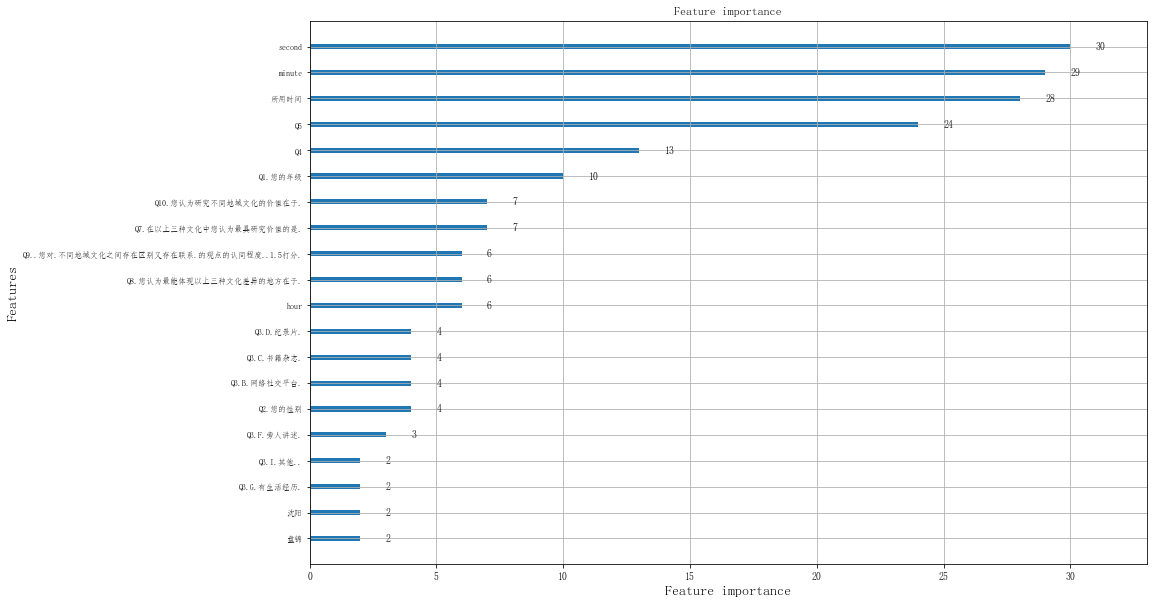

In [48]:
import matplotlib.pyplot as plt
plt.rc("font",family='FangSong')
fig, ax = plt.subplots(figsize=(15,10))
lgb.plot_importance(bst, max_num_features=20, ax=ax
                    #,importance_type='gain'
                   )
plt.yticks(fontsize=8)
plt.xlabel('Feature importance',fontsize=14)
plt.ylabel('Features',fontsize=14)
plt.savefig("12_feature_importance_Q6.svg", format="svg")

In [19]:
def train_predict(train,test,params):
    label = 'target'
    features = [f for f in train.columns if f not in ['id','target']]
    params = params_append(params)
    kf = sk.model_selection.KFold(n_splits=5,random_state=2020,shuffle=True)
    prediction_test = 0
    cv_score = []
    prediction_train = pd.Series()
    ESR = 30
    NBR = 10000
    VBE = 50
    for train_part_index,eval_index in kf.split(train[features],train[label]):
        train_part = lgb.Dataset(train[features].loc[train_part_index],train[label].loc[train_part_index])
        eval = lgb.Dataset(train[features].loc[eval_index],train[label].loc[eval_index])
        bst = lgb.train(params,train_part,num_boost_round=NBR,valid_sets=[train_part,eval],
                        valid_names=['train','valid'],early_stopping_rounds=ESR,verbose_eval=VBE)
        prediction_test += bst.predict(test[features])
        prediction_train = prediction_train.append(pd.Series(
        bst.predict(train[features].loc[eval_index]), index=eval_index))
        eval_pre = bst.predict(train[features].loc[eval_index])
        score = np.sqrt(sk.metrics.mean_absolute_error(train[label].loc[eval_index].values,eval_pre))
        cv_score.append(score)
        print(cv_score,sum(cv_score) / 5)
        pd.Series(prediction_train.sort_index().values).to_csv(
        "./Desktop/com result/train_lightgbm.csv",index = False)
        pd.Series(prediction_test / 5).to_csv("./Desktop/com result/test_lightgbm.csv",index=False)
        test['target'] = prediction_test/5
        test[['id','target']].to_csv("./Desktop/com result/submission_lightgbm.csv",index=False)
        return

In [69]:
# params ={'bagging_fraction': 0.6823987306284804,
#  'bagging_freq': 6,
#  'feature_fraction': 0.8339345194845146,
#  'learning_rate': 0.32407483695598555,
#  'min_child_samples': 0,
#  'num_leaves': 17,
#  'reg_alpha': 1,
#  'reg_lambda': 1.3606826444137012}

In [21]:
train_predict(train,test,params)

NameError: name 'test' is not defined